In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import shap

In [2]:
data = pd.read_csv('encoded_training.csv')
data

,ID,PATID,UCX_abnormal,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,...,ua_wbc,age,Urinary_tract_infections,abxUTI,ethnicity_Hispanic or Latino,ethnicity_Non-Hispanic,ethnicity_Patient Refused,ethnicity_Unknown,ethnicity_not_reported,Female
0,34660,22882,1,4,0,0,1,1,1,0,...,2,53,0,1,False,True,False,False,False,True
1,21796,14379,0,1,1,0,0,1,1,0,...,1,30,0,1,False,True,False,False,False,True
2,73901,50935,1,2,0,3,1,1,-1,0,...,3,52,0,1,False,True,False,False,False,True
3,31039,20477,0,2,0,1,-1,1,1,0,...,2,43,0,1,False,True,False,False,False,False
4,52301,35273,1,4,0,0,1,1,3,0,...,2,49,0,1,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13271,72561,50001,0,4,1,0,1,1,3,0,...,2,54,0,0,False,True,False,False,False,True
13272,9820,6476,0,-1,0,0,0,1,-1,0,...,-1,52,0,0,False,True,False,False,False,False
13273,49819,33460,1,2,0,2,1,1,1,0,...,2,42,0,1,False,True,False,False,False,True
13274,17174,11391,1,1,0,0,0,0,1,0,...,2,33,0,1,False,True,False,False,False,True


In [3]:
# Define features and target
X = data.drop(columns=['UCX_abnormal', 'ID', 'PATID'])  # Dropping ID columns and target
y = data['UCX_abnormal']

In [4]:
# Optional: Standardize features if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Define the Optuna objective function for LightGBM
def objective(trial):
    # Suggest hyperparameters for the LightGBM model
    num_leaves = trial.suggest_int('num_leaves', 10, 200)
    max_depth = trial.suggest_int('max_depth', -1, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    
    
    # Define the LightGBM model
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree
        'force_row_wise': True,
    )
    
    # Perform cross-validation
    score = cross_val_score(model, X_scaled, y, cv=3, scoring='accuracy')
    
    # Return the negative mean score (Optuna minimizes)
    return -score.mean()

In [6]:
# Create a study object for LightGBM
study = optuna.create_study(direction='minimize')  # Minimize the negative accuracy

[I 2024-09-25 23:00:58,793] A new study created in memory with name: no-name-734ec41b-6a48-4a45-9735-6c8ae6093552


In [7]:
# Optimize the study
study.optimize(objective, n_trials=30)  # Run the optimization for 50 trials

[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Info] Number of positive: 4430, number of negative: 4421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 8851, number of used features: 25
[LightGBM] [Info] [binary:Bo

[I 2024-09-25 23:01:01,842] Trial 0 finished with value: -0.7732004258350118 and parameters: {'num_leaves': 117, 'max_depth': 18, 'learning_rate': 0.00014477128509730433, 'n_estimators': 236, 'min_child_samples': 9, 'subsample': 0.5161561372527813, 'colsample_bytree': 0.9199027572165357}. Best is trial 0 with value: -0.7732004258350118.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:04,066] Trial 1 finished with value: -0.7764387802601135 and parameters: {'num_leaves': 115, 'max_depth': 15, 'learning_rate': 0.00021425995510025397, 'n_estimators': 220, 'min_child_samples': 46, 'subsample': 0.6704410174032921, 'colsample_bytree': 0.5160376853551782}. Best is trial 1 with value: -0.7764387802601135.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Info] Number of positive: 4430, number of negative: 4421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8851, number of used features: 24
[LightGBM] [Info] [binary:Bo

[I 2024-09-25 23:01:07,083] Trial 2 finished with value: -0.7774934792950065 and parameters: {'num_leaves': 112, 'max_depth': 18, 'learning_rate': 0.00019847093260912224, 'n_estimators': 272, 'min_child_samples': 22, 'subsample': 0.8462536588505822, 'colsample_bytree': 0.8720797518201189}. Best is trial 2 with value: -0.7774934792950065.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Info] Number of positive: 4430, number of negative: 4421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 8851, number of used features: 23
[LightGBM] [Info] [binary:Bo

[I 2024-09-25 23:01:07,693] Trial 3 finished with value: -0.7686053052370728 and parameters: {'num_leaves': 19, 'max_depth': 17, 'learning_rate': 0.0025907958738215836, 'n_estimators': 142, 'min_child_samples': 86, 'subsample': 0.8178021907934532, 'colsample_bytree': 0.9922436081829349}. Best is trial 2 with value: -0.7774934792950065.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 8851, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500508 -> initscore=0.002034
[LightGBM] [Info] Start training from score 0.002034
[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] 

[I 2024-09-25 23:01:08,338] Trial 4 finished with value: -0.7668729634763931 and parameters: {'num_leaves': 84, 'max_depth': 5, 'learning_rate': 0.000301529491045635, 'n_estimators': 98, 'min_child_samples': 15, 'subsample': 0.9558553579551838, 'colsample_bytree': 0.9233919560896933}. Best is trial 2 with value: -0.7774934792950065.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:09,149] Trial 5 finished with value: -0.749548099187901 and parameters: {'num_leaves': 39, 'max_depth': 4, 'learning_rate': 0.8256114582839921, 'n_estimators': 278, 'min_child_samples': 53, 'subsample': 0.6694424953015604, 'colsample_bytree': 0.6842657938720396}. Best is trial 2 with value: -0.7774934792950065.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-25 23:01:10,534] Trial 6 finished with value: -0.772446687652061 and parameters: {'num_leaves': 153, 'max_depth': 5, 'learning_rate': 0.001084070133228379, 'n_estimators': 284, 'min_child_samples': 80, 'subsample': 0.8078542140243083, 'colsample_bytree': 0.6746797207692146}. Best is trial 2 with value: -0.7774934792950065.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-25 23:01:14,062] Trial 7 finished with value: -0.7718442893942062 and parameters: {'num_leaves': 161, 'max_depth': 14, 'learning_rate': 0.00010586370204497992, 'n_estimators': 296, 'min_child_samples': 62, 'subsample': 0.8522528144554806, 'colsample_bytree': 0.8355208179262682}. Best is trial 2 with value: -0.7774934792950065.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4430, number of negative: 4421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 8851, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500508 -> initscore=0.002034
[L

[I 2024-09-25 23:01:16,061] Trial 8 finished with value: -0.7742543419598112 and parameters: {'num_leaves': 34, 'max_depth': 10, 'learning_rate': 0.10591492027797296, 'n_estimators': 299, 'min_child_samples': 34, 'subsample': 0.8284233962795964, 'colsample_bytree': 0.7580360611229091}. Best is trial 2 with value: -0.7774934792950065.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Info] Number of positive: 4430, number of negative: 4421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 8851, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500508 -> initscore=0.002034
[LightGBM] [I

[I 2024-09-25 23:01:16,765] Trial 9 finished with value: -0.7756101209851392 and parameters: {'num_leaves': 13, 'max_depth': 0, 'learning_rate': 0.008293141001944927, 'n_estimators': 128, 'min_child_samples': 37, 'subsample': 0.6191828765979266, 'colsample_bytree': 0.5792622909083041}. Best is trial 2 with value: -0.7774934792950065.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 8851, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500508 -> initscore=0.002034
[LightGBM] [Info] Start training from score 0.002034
[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:Bo

[I 2024-09-25 23:01:19,385] Trial 10 finished with value: -0.7781711220207931 and parameters: {'num_leaves': 194, 'max_depth': 11, 'learning_rate': 0.03824010654993398, 'n_estimators': 188, 'min_child_samples': 24, 'subsample': 0.9764890761687478, 'colsample_bytree': 0.8152159626152709}. Best is trial 10 with value: -0.7781711220207931.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:22,883] Trial 11 finished with value: -0.7713922439139379 and parameters: {'num_leaves': 198, 'max_depth': 20, 'learning_rate': 0.04912839179979043, 'n_estimators': 196, 'min_child_samples': 23, 'subsample': 0.9910702749864893, 'colsample_bytree': 0.8039777573100518}. Best is trial 10 with value: -0.7781711220207931.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:23,906] Trial 12 finished with value: -0.7794521841915133 and parameters: {'num_leaves': 194, 'max_depth': 11, 'learning_rate': 0.03498156519853665, 'n_estimators': 60, 'min_child_samples': 26, 'subsample': 0.9122228540591972, 'colsample_bytree': 0.8685485964592748}. Best is trial 12 with value: -0.7794521841915133.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:24,942] Trial 13 finished with value: -0.78088312258585 and parameters: {'num_leaves': 200, 'max_depth': 11, 'learning_rate': 0.05354765127818866, 'n_estimators': 57, 'min_child_samples': 31, 'subsample': 0.9218730617154269, 'colsample_bytree': 0.7296273421772531}. Best is trial 13 with value: -0.78088312258585.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:25,916] Trial 14 finished with value: -0.7667219979865595 and parameters: {'num_leaves': 162, 'max_depth': 8, 'learning_rate': 0.2901019686513259, 'n_estimators': 77, 'min_child_samples': 5, 'subsample': 0.9141740900905345, 'colsample_bytree': 0.691251642618986}. Best is trial 13 with value: -0.78088312258585.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:26,498] Trial 15 finished with value: -0.7766647349211091 and parameters: {'num_leaves': 183, 'max_depth': 13, 'learning_rate': 0.009820958076587116, 'n_estimators': 55, 'min_child_samples': 68, 'subsample': 0.9072473635091189, 'colsample_bytree': 0.7487501100240845}. Best is trial 13 with value: -0.78088312258585.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-25 23:01:27,396] Trial 16 finished with value: -0.7838957265873715 and parameters: {'num_leaves': 144, 'max_depth': 8, 'learning_rate': 0.03518102920288046, 'n_estimators': 107, 'min_child_samples': 37, 'subsample': 0.7492155034953107, 'colsample_bytree': 0.6245666627942468}. Best is trial 16 with value: -0.7838957265873715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-25 23:01:28,482] Trial 17 finished with value: -0.7737270690313954 and parameters: {'num_leaves': 140, 'max_depth': 8, 'learning_rate': 0.22209575723982264, 'n_estimators': 112, 'min_child_samples': 39, 'subsample': 0.7494684475532379, 'colsample_bytree': 0.6116184562679536}. Best is trial 16 with value: -0.7838957265873715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-09-25 23:01:28,937] Trial 18 finished with value: -0.7395304752008972 and parameters: {'num_leaves': 74, 'max_depth': 1, 'learning_rate': 0.0031508863901591297, 'n_estimators': 154, 'min_child_samples': 58, 'subsample': 0.7435331164671326, 'colsample_bytree': 0.6151997678140124}. Best is trial 16 with value: -0.7838957265873715.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 8851, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500508 -> initscore=0.002034
[LightGBM] [Info] Start training from score 0.002034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-25 23:01:29,637] Trial 19 finished with value: -0.7783218151940723 and parameters: {'num_leaves': 146, 'max_depth': 7, 'learning_rate': 0.019032457511502798, 'n_estimators': 89, 'min_child_samples': 97, 'subsample': 0.6773720781987927, 'colsample_bytree': 0.5127151798256588}. Best is trial 16 with value: -0.7838957265873715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-25 23:01:30,157] Trial 20 finished with value: -0.7863817724914326 and parameters: {'num_leaves': 175, 'max_depth': 3, 'learning_rate': 0.12062303394456622, 'n_estimators': 161, 'min_child_samples': 46, 'subsample': 0.5593114556906877, 'colsample_bytree': 0.7367836752126614}. Best is trial 20 with value: -0.7863817724914326.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:30,829] Trial 21 finished with value: -0.784348061403979 and parameters: {'num_leaves': 176, 'max_depth': 3, 'learning_rate': 0.11338602103888207, 'n_estimators': 160, 'min_child_samples': 45, 'subsample': 0.5218591433372143, 'colsample_bytree': 0.7431349160957974}. Best is trial 20 with value: -0.7863817724914326.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 8851, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500508 -> initscore=0.002034
[LightGBM] [Info] Start training from score 0.002034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:31,305] Trial 22 finished with value: -0.7811089921479223 and parameters: {'num_leaves': 175, 'max_depth': 2, 'learning_rate': 0.12591974117566274, 'n_estimators': 170, 'min_child_samples': 46, 'subsample': 0.5359307327209404, 'colsample_bytree': 0.6420978090187617}. Best is trial 20 with value: -0.7863817724914326.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-25 23:01:33,012] Trial 23 finished with value: -0.746158336758565 and parameters: {'num_leaves': 134, 'max_depth': -1, 'learning_rate': 0.6678530073818921, 'n_estimators': 122, 'min_child_samples': 44, 'subsample': 0.5720166280999672, 'colsample_bytree': 0.723981634549618}. Best is trial 20 with value: -0.7863817724914326.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:33,630] Trial 24 finished with value: -0.7815610035886215 and parameters: {'num_leaves': 172, 'max_depth': 2, 'learning_rate': 0.32617372958701785, 'n_estimators': 167, 'min_child_samples': 70, 'subsample': 0.589889209935944, 'colsample_bytree': 0.7824029585668879}. Best is trial 20 with value: -0.7863817724914326.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-25 23:01:34,372] Trial 25 finished with value: -0.7825401007401053 and parameters: {'num_leaves': 132, 'max_depth': 4, 'learning_rate': 0.10769175682985671, 'n_estimators': 206, 'min_child_samples': 52, 'subsample': 0.5015041680582402, 'colsample_bytree': 0.593619857293441}. Best is trial 20 with value: -0.7863817724914326.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:35,279] Trial 26 finished with value: -0.7823140950197557 and parameters: {'num_leaves': 179, 'max_depth': 6, 'learning_rate': 0.02089623894178386, 'n_estimators': 142, 'min_child_samples': 51, 'subsample': 0.6253082603695752, 'colsample_bytree': 0.648105517856786}. Best is trial 20 with value: -0.7863817724914326.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-25 23:01:36,151] Trial 27 finished with value: -0.7826154473267449 and parameters: {'num_leaves': 93, 'max_depth': 3, 'learning_rate': 0.15762607191854253, 'n_estimators': 248, 'min_child_samples': 61, 'subsample': 0.566222569381614, 'colsample_bytree': 0.5332220994811179}. Best is trial 20 with value: -0.7863817724914326.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:38,511] Trial 28 finished with value: -0.750225963170888 and parameters: {'num_leaves': 163, 'max_depth': -1, 'learning_rate': 0.4670470390719074, 'n_estimators': 152, 'min_child_samples': 41, 'subsample': 0.7096493993715239, 'colsample_bytree': 0.708092105826788}. Best is trial 20 with value: -0.7863817724914326.


[LightGBM] [Info] Number of positive: 4430, number of negative: 4420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500565 -> initscore=0.002260
[LightGBM] [Info] Start training from score 0.002260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-09-25 23:01:40,267] Trial 29 finished with value: -0.7790749576845605 and parameters: {'num_leaves': 126, 'max_depth': 8, 'learning_rate': 0.07110202460394369, 'n_estimators': 183, 'min_child_samples': 13, 'subsample': 0.6268448121360534, 'colsample_bytree': 0.5561433776415143}. Best is trial 20 with value: -0.7863817724914326.


In [8]:
# Get the best parameters
print(f"Best parameters: {study.best_params}")
print(f"Best score: {-study.best_value}")


Best parameters: {'num_leaves': 175, 'max_depth': 3, 'learning_rate': 0.12062303394456622, 'n_estimators': 161, 'min_child_samples': 46, 'subsample': 0.5593114556906877, 'colsample_bytree': 0.7367836752126614}
Best score: 0.7863817724914326


In [9]:
# Train the final model using the best parameters
best_params = study.best_params
final_model = lgb.LGBMClassifier(**best_params)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model on the training set
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

[LightGBM] [Info] Number of positive: 5260, number of negative: 5360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 10620, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495292 -> initscore=-0.018833
[LightGBM] [Info] Start training from score -0.018833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [10]:
# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.7850
Precision: 0.7997
Recall: 0.7841
F1 Score: 0.7918
Confusion Matrix:
[[ 999  272]
 [ 299 1086]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1271
           1       0.80      0.78      0.79      1385

    accuracy                           0.79      2656
   macro avg       0.78      0.79      0.78      2656
weighted avg       0.79      0.79      0.79      2656



In [11]:
final_model.booster_.save_model('lightgbm_model.txt')

In [12]:
explainer = shap.TreeExplainer(final_model)

# 2. Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# 3. Summarize SHAP values to get feature importance
importance_df = pd.DataFrame({
    'Importance': np.abs(shap_values).mean(axis=0)  # Mean of absolute SHAP values for each feature
})

C:\Users\Luke Santibanez\AppData\Roaming\Python\Python39\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


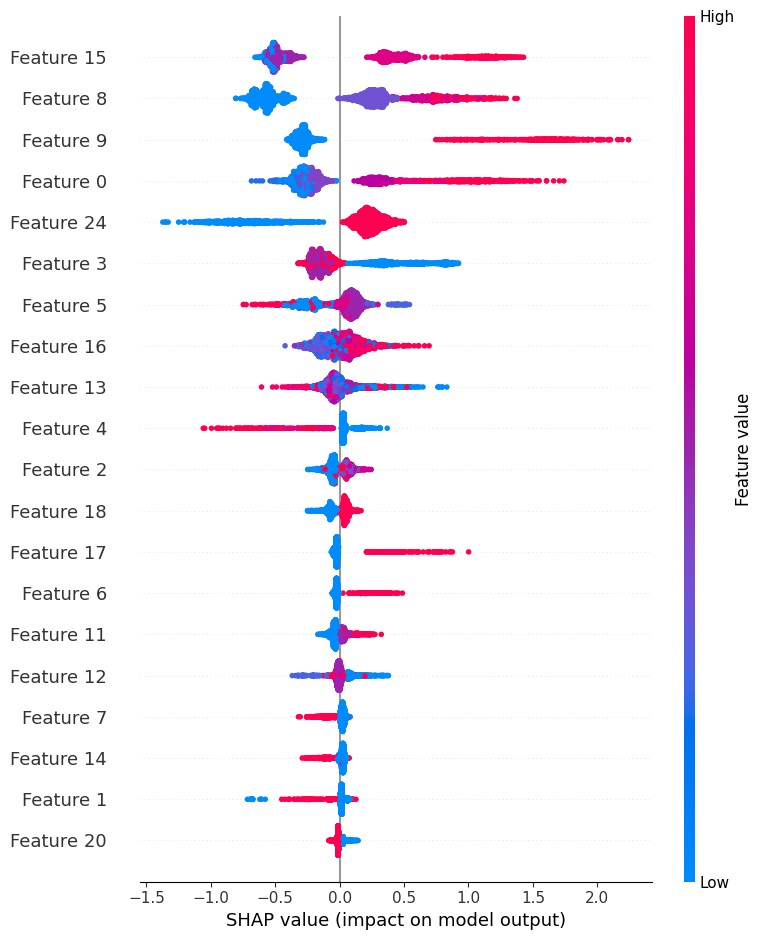

In [13]:
shap.summary_plot(shap_values, X_test)

In [14]:
original_feature_names = X.columns
importance_df['Feature'] = [original_feature_names[i] for i in range(len(original_feature_names))]
top_10_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

print(top_10_features)

    Importance       Feature
15    0.527113        ua_wbc
8     0.499138       ua_leuk
9     0.482880    ua_nitrite
0     0.374893   ua_bacteria
24    0.342210        Female
3     0.225814    ua_clarity
5     0.151362        ua_epi
16    0.115153           age
13    0.095105  ua_spec_grav
4     0.076542      ua_color
